In [1]:
# 라이브러리 불러오기 
import pandas as pd
import numpy as np
import seaborn as sns ### 데이터셋
import matplotlib.pyplot as plt ### 시각화

from itertools import combinations 
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics ### 메트릭
from sklearn.model_selection import train_test_split, GridSearchCV ### 데이터 분할, 그리드서치
from sklearn.ensemble import RandomForestClassifier ### 랜덤포레스트
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

In [2]:
# 그래프 한글 표현
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 목표 : 붓꼴 종을 분류하라 - RandomForest 사용하기

## 데이터 불러오기
iris = sns.load_dataset('iris')

## 데이터 분석하기
- 데이터가 어떻식으로 구성되었는 지 아는 것이 가장 중요하다.
- info(), isnull() 등과 같은 여러 함수를 사용해서 데이터를 들여다 보자.
- 대충 파악이 되면 그래프로도 한번 더 확인 해보자.

In [ ]:
## 결측치 확인
print(iris.isnull().sum())

### 붓꽃데이터는 결측치가 존재하지 않는다.
### 모든 데이터가 붓꽃과 같이 데이터가 깔끔하지 않는다.
### 그럴 때는 결측치를 추가하거나 제거하는 경우도 있다.
### pandas를 잘 사용하면 데이터를 다루기 쉽다. 
### 행을 추가할 수도 있고 열을 추가할 수도 있고 또한 삭제할 수도 있다.

In [ ]:
## 데이터 자세하게 확인

print(iris.info())
### 꽃잎과 꽃받침의 데이터 타입은 정수이다
### species의 타입은 object로 보인다.
### 데이터 처리는 정수타입인 경우에만 가능하다.
### 레이블 인코딩 또는 원핫인코딩을 이용해서 타입을 변경해줘야 한다.
### 모델 자체에 내부인코딩 기능이 있는 경우도 있다.

### 핵심은
### 컴퓨터는 숫자로만 받아들이기 때문에
### 정수형 데이터로 전부 변환해서 데이터를 처리해야한다.!!!!!!!

#### 데이터 프레임 활용하기

In [4]:
iris_df = iris
iris_df.head() ### head()의 defalut 값은 5
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [ ]:
print(iris['species'].value_counts().sum()) 

iris_df.groupby(iris_df['species']).count() 
### 종을 기준으로 나머지 특성의 분포
### 각각의 특성이 몇개가 있는 지 확인 
### >> 분포가 일정하면 데이터를 분할할 때 stratify를 사용하지 않아도 된다.
### 즉 원본데이터의 비율이 일정한 지 알아보기 위함이다.

### 같은 코드지만 두번째 코드가 더 직관적으로 데이터의 분포를 알수있다.


In [ ]:
iris_df.groupby(iris_df['species']).mean() 
### 각 특성의 평균 값

### 평균값을 보면 평균적으로 어떤 종류의 꽃이 큰지 알 수있다.
### 붓꽃을 분류하는데 있어서 큰 도움은 안되지만 
### 데이터를 보는 눈을 기르기 위해서 작성해보자.

In [ ]:
## 데이터 시각화
### g = sns.pairplot(iris, hue='species', markers='+') // 밑에 코드와 같은 의미다.
g = sns.pairplot(iris.iloc[:,:], hue='species', markers='+')
plt.show()
### pairplot:  데이터에 모든 변수를 서로 비교하는 산점도 그리다.
###            데이터 변수가 많을 경우에는 좀 복잡하게 보일수도 있다.

'''
 sepal : 꽃받침 , petal : 꽃잎
'''

## 데이터 분류 및 모델 학습
**RandomForest**
- 분류나 회귀 어떠한 경우에도 사용이 가능하다.
- 사용하는 가장 큰 이유는 과대적합의 문제를 피할수 있다.
- 트리수의 따라서 결과값이 달라지기 때문에 트리수를 정하는 것이 포인트다.
- KNN 모델처럼 반복문을 통해서 트리수를 결정하는 것도 좋은 방법이다.
- 하지만 RandomForest 모델은 고차원데이터에 적합하다.
- 해당 데이터는 정말 단순하기 때문에 굳이 RandomForest를 사용하지 않아도 될 것같다.


#### Version1 - 기본, 하이퍼파라미터 튜닝x, 교차검증 x 

In [5]:
## 데이터 훈련용과 테스트용 분류
X = iris.drop('species', axis=1) ### 타겟변수 제거
y = iris['species'] ### 타겟변수

le = LabelEncoder() ### 레이블 인코딩
y = le.fit_transform(iris['species']) ### 숫자형 타입으로 변환해준다. >> 결정경계를 그리기 위함이다.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [45]:
RF = RandomForestClassifier(n_estimators=100, random_state=0) ### 트리수 임의로 지정
RF.fit(X_train, y_train) ### 모델 학습시키기

## 훈련용 데이터 정확도
y_train_pred = RF.predict(X_train)
print('Train_Accuracy:', accuracy_score(y_train, y_train_pred)) 

## 테스트용 데이터 정확도
y_Test_pred = RF.predict(X_test) ### 예측값
print('Test_Accuracy:', accuracy_score(y_test, y_Test_pred)) ### 실제값 예측값 비교

text = ''' 
훈련용 정확도가 1이 나오는 건 모델이 데이터를 확실하게 학습했다는 증거다.

테스트용 정확도가 0.977이 나오는 건 과적합으로 보일 수 있지만, 현재 붓꽃 데이터
는 아주 단순한 데이터라서 어쩔 수 없다. 대신 1이 나오지 않았다는 부분에서 일반화가
잘 되고 있다는 걸로 보인다. 
'''
print(text)


Train_Accuracy: 1.0
Test_Accuracy: 0.9777777777777777
 
훈련용 정확도가 1이 나오는 건 모델이 데이터를 확실하게 학습했다는 증거다.

테스트용 정확도가 0.977이 나오는 건 과적합으로 보일 수 있지만, 현재 붓꽃 데이터
는 아주 단순한 데이터라서 어쩔 수 없다. 대신 1이 나오지 않았다는 부분에서 일반화가
잘 되고 있다는 걸로 보인다. 



#### Version2 - 하이퍼파라미터 튜닝o - 수동설정

In [29]:
RF = RandomForestClassifier(n_estimators=100, ### 트리수 임의로 지정
                            max_features='sqrt', ### sqrt : 기능수(여기서는 4)
                            max_depth=None, ### 트리 최대 깊이
                            min_samples_split=2, ### 내부 노드 분할 샘플수
                            min_samples_leaf=1, ### 노드 최소 샘플수
                            bootstrap=True, ### 데이터 무작위 여부/ 여기선 사용 True
                            random_state=0) 

RF.fit(X_train, y_train) ### 모델 학습시키기

## 훈련용 데이터 정확도
y_train_pred = RF.predict(X_train)
print('Train_Accuracy:', accuracy_score(y_train, y_train_pred)) 

## 테스트용 데이터 정확도
y_Test_pred = RF.predict(X_test) ### 예측값
print('Test_Accuracy:', accuracy_score(y_test, y_Test_pred)) ### 실제값 예측값 비교

text = ''' 
Version1과 같은 결과값이 나온다. 위에서 설정한 하이퍼 파라미터의 값이
기본설정이기 때문이다. 즉 따로 하이퍼파라미터를 설정해주지 않으면 default값으로
설정되는데 수동으로 설정한 하이퍼파라미터와 수치가 같다는 말이다.

어떤 하이퍼파라미터가 있는 지 확인하기 위해서 코드를 작성했다.
'''
print(text)

Train_Accuracy: 1.0
Test_Accuracy: 0.9777777777777777
 
Version1과 같은 결과값이 나온다. 위에서 설정한 하이퍼 파라미터의 값이
기본설정이기 때문이다. 즉 따로 하이퍼파라미터를 설정해주지 않으면 default값으로
설정되는데 수동으로 설정한 하이퍼파라미터와 수치가 같다는 말이다.

어떤 하이퍼파라미터가 있는 지 확인하기 위해서 코드를 작성했다.



#### Version3 - 하이퍼파라미터 튜닝o - GridSearch 사용 - 교차검증


##### 교차검증

**왜 사용하냐?**
- 목적에 맞게 모델을 구성하고 훈련용 데이터를 이용해서 데이터를 학습시켰다. 그 다음에 새로운 데이터를 넣어서 결과를 도출해야한다....
- 하지만 모델이 제대로 작동하는 지 모르기 때문에 무작정 새로운 데이터를 넣어서 학습 시킬 수는 없다. 왜냐 시간과 비용이 들기 때문이다.
- 그래서 교차검증을 통해서 모델의 성능을 미리 판단하고, 문제가 없을 경우에 새로운 데이터를 넣어 결과를 도출한다면 시간과 비용을 아낄수 있다.

**교차검증수치의 좋고 나쁨을 판단하는 기준이 뭔가?**
- 주어진 데이터나 상황에 따라 점수의 기준이 달라진다. 
- 기준을 판단하는데 있어 가장 쉬운 방법은 캐글같은 데이터 대회 사이트의 도메인 전문가의 결과물과 비교하는 것이다.
- 내가 구성한 모델의 교차검증 점수와 전문가가 구성한 모델의 교차검증 점수를 비교하는 방법이다.
- 추후에 프로젝트를 할 때 교차검증과 같은 모델의 성능을 판단하는 건 정말 중요하기 때문에
- 꼭 꼭 교차검증을 하는 이유와 방법에 대해서 기억하자.

####

In [ ]:
RF = RandomForestClassifier(random_state=0)

## 하이퍼파라미터 설정 - 딕셔너리
param_grid={
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth' : [None, 5, 10],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [1, 2],
    'bootstrap' : [True, False]
}

## GridSearch 객체 생성
grid_search = GridSearchCV(estimator=RF, ### 모델 설정
                          param_grid=param_grid, ### 하이퍼파라미터 설정(하이퍼파리미터의 조합은 상황에 맞춰서 하자.)
                          cv=5) ### 교차검증 
                                ### 학습용데이터를 5개로 분류한다.
                                ### 그 중에서 4개는 학습용데이터 1개는 검증용 데이터로 나눈다.(cv=6이면 5개와 1개로 구분.)
                                ### 위와 같은 과정을 5번 반복하는데 그게 "CV = 5" 라는 말이다.
                                ### 5개의 교차검증수치를 평균을 낸다

grid_search.fit(X_train, y_train) ### 모델 학습 

cv_results_df = pd.DataFrame(grid_search.cv_results_) ### 교차검증 수치를 데이터프레임을 통해 출력한다.
#print(cv_results_df.sort_values(by='std_score_time', ascending=False).head()) ### by=''를 기준으로 내림차순 정렬 후 상위 5개 출력

print("Best paramters: ", grid_search.best_params_) ### 최상의 하이퍼파라미터 출력
print("Best score: ", grid_search.best_score_) ### 교차검증 점수 출력
                                               ### 교차검증 점수가 좋으면
                                               ### 테스트용 데이터로 결과를 도출하자.
                                               ### 좋지 않다면 모델을 개선시켜야 한다.

## 최상의 하이퍼파라미터 모델 학습
best_model = grid_search.best_estimator_ ### 최상의 하이퍼파라미터를 모델에 저장.
best_model.fit(X_train, y_train) ### 최상위 모델 학습
y_pred = best_model.predict(X_test) ### 예측값 변수 초기화
print("Accuracy: ", accuracy_score(y_test, y_pred)) ### 예측값과 실제값을 비교

text = '''
!! GridSearch !!
최상의 하이퍼파라미터 조합을 찾을 수 있다. 하지만
훈련시간이 정말 오래걸린다. 해당 데이터는 정말 단순하기 때문에 47.6초가 
걸렸지만 이것보다 더 많은 데이터를 다룰 때는 많은 시간과 비용이 든다.
하지만 그만큼 성능이 좋은 모델을 구성할 수 있다. 
(교차검증 필수.... 그러나 교차검증만 따로 사용 가능.)

!! 교차검증 !!
GridSearch에서 교차검증은 필수다. 교차검증을 통해 최상의 하이퍼파라미터 
조합을 찾을수 있다.그럼 당연히 교차검증을 통한 수치를 확인할 필요가 있다.
교차검증을 통해서 할 수 있는 핵심은 성능 추정치를 제공하는 것이다.

성능추정치(교차검증수치)를 통해서 새로운 데이터의 학습을 예측할 수 있다.
즉 교차검증수치는 모델의 성능이 얼마나 뛰어난가를 보여주는 수치다.
'''
print(text)


#### PCA
- 고차원 데이터를 2차원으로 축소 시켜서 그래프로 나타내는 기법
- 그려진 그래프를 통해서 모델이 어떻게 데이터를 분류하는 지 시각적으로 판단이 가능하게 한다.
- 즉 모델이 학습하는데 있어서 직접적으로 영향을 주지는 않지만 모델의 성능을 판단하는데 있어서 도움이 된다.

C:\Users\HA SEONG JIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


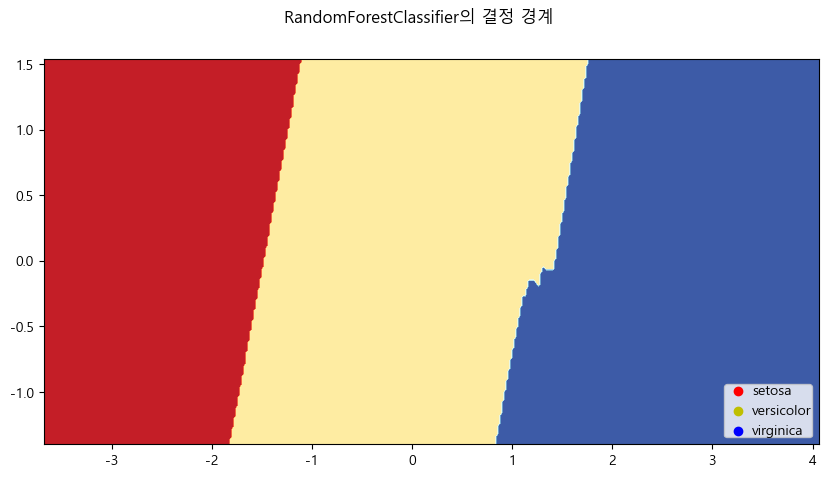

In [8]:
pca = PCA(n_components=2).fit(X_train) ### PCA 객체 생성(주성분 2개) > PCA로 학습 시켜서 4D를 2D로 축소.
pca_2d = pca.transform(X_train) ### pca객체에 맞춰서 학습용 데이터 성분을 2개의 주성분으로 변환.

colors = 'ryb'  ### 컬러 지정
cmap = plt.cm.RdYlBu ###

plot_step = 0.02 ### meshgrid를 위한 스텝 크기

plt.figure(figsize=(10, 5)) ### 그래프 사이즈

## 학습 데이터 점 그리기
for color, i, target_name in zip(colors, [0, 1, 2], le.classes_):
    plt.scatter(pca_2d[y_train == i, 0], pca_2d[y_train == i, 1], color=color, label=target_name)

plt.suptitle("RandomForestClassifier의 결정 경계") ### 그래프 제목
plt.legend(loc='lower right', borderpad=0, handletextpad=0) ### 범례설정
plt.axis("tight") ### 축 속성 완전 타이트하게

## 2차원 공간에 있는 가능한 모든 점에 대한 그리드 생성
x_min, x_max = pca_2d[:, 0].min() - 1, pca_2d[:, 0].max() + 1 ### x 범위 설정
y_min, y_max = pca_2d[:, 1].min() - 1, pca_2d[:, 1].max() + 1 ### y 범위 설정
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), ### xx ,yy 좌표 생성
                     np.arange(y_min, y_max, plot_step))

## 그리드의 각 점에 대해 예측
Z = best_model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])) ### 코드 
                                                                             ### ravel(): 다차원 배열을 1차원 배열로 변환
                                                                             ### np.c[] : 주어진 1차원 배열들을 열방향으로 결합해서 
                                                                             ###          새로운 2차원 배열을 생성한다.
                                                                             ### ex)      [1,2,3] --> [[1, 4],
                                                                             ###          [4,5,6]      [2, 5],      
                                                                             ###                       [3, 6]]
                                                                                    
Z = Z.reshape(xx.shape)

## 결정 경계 그리기
cs = plt.contourf(xx, yy, Z, cmap=cmap)

plt.show()

#### 중요도 그래프 그리기

Feature: 0, score: 0.09495
Feature: 1, score: 0.02255
Feature: 2, score: 0.46897
Feature: 3, score: 0.41352


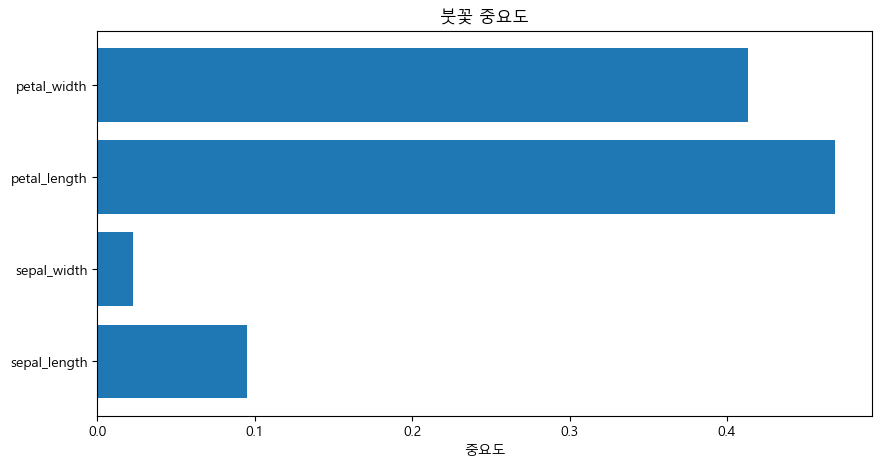

In [67]:
## 중요도 그래프 그려서 출력하기
importance = best_model.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, score: %.5f' % (i,v))

plt.figure(figsize=(10,5))
plt.barh([x for x in range(len(importance))], importance, tick_label=X_train.columns)
plt.title('붓꽃 중요도')
plt.xlabel('중요도')
plt.show()